##**Importing Neccessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import string
from nltk.corpus import stopwords
import os
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn import model_selection
from sklearn import svm
from nltk import word_tokenize
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
import pickle
from sklearn.metrics import ConfusionMatrixDisplay

##**Creating Class to read data**

In [2]:
#Parent Class for Data
class data_read_write(object):
    def __init__(self):
        pass
    def __init__(self, file_link):
        self.data_frame =  pd.read_csv(file_link)
    def read_csv_file(self, file_link):
        #data_frame_read = pd.read_csv(file_link)
        #return data_frame_read
        #self.data_frame = pd.read_csv(file_link)
        return self.data_frame
    def write_to_csvfile(self, file_link):
        self.data_frame.to_csv(file_link, encoding='utf-8', index=False, header=True)
        return


###**Child class to remove stop words and generate word cloud**

In [3]:
#Child Class for Data_read_write
class generate_word_cloud(data_read_write):
    def __init__(self):
        pass
    #Child own Function
    def variance_column(self, data):
        return variance(data)
    #Polymorphism
    def word_cloud(self, data_frame_column, output_image_file):
        text = " ".join(review for review in data_frame_column)
        stopwords = set(STOPWORDS)
        stopwords.update(["subject"])
        wordcloud = WordCloud(width = 1200, height = 800, stopwords=stopwords, max_font_size = 50, margin=0, background_color = "white").generate(text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        wordcloud.to_file(output_image_file)
        return

##**Preprocessing Data (Removing Punctuation)**

In [4]:
#Child Class for Data_read_write
class data_cleaning(data_read_write):
    def __init__(self):
        pass
    def message_cleaning(self, message):
            Test_punc_removed = [char for char in message if char not in string.punctuation]
            Test_punc_removed_join = ''.join(Test_punc_removed)
            Test_punc_removed_join_clean = [word for word in Test_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
            final_join = ' '.join(Test_punc_removed_join_clean)
            return final_join


    def apply_to_column(self, data_column_text):
        data_processed = data_column_text.apply(self.message_cleaning)
        return data_processed





##**Vectorizing Data**
##**Initializing Algorithms and there evluation metrices**
**Models Used are : Multinomial NB, SVM, J48**

In [27]:
#Child Class for Data_read_write
class apply_embeddding_and_model(data_read_write):
    def __init__(self):
        pass
    def apply_count_vector(self, v_data_column):
        vectorizer = CountVectorizer(min_df=2,analyzer = "word",tokenizer = None,preprocessor = None,stop_words = None)
        with open('vectorizer.pkl', "wb") as f:
          pickle.dump(vectorizer, f)

        return vectorizer.fit_transform(v_data_column)


    def apply_naive_bayes(self, X, y):
        #DIVIDE THE DATA INTO TRAINING AND TESTING PRIOR TO TRAINING
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        #Training model
        NB_classifier = MultinomialNB()
        NB_classifier.fit(X_train, y_train)
        # Predicting the Test set results
        y_predict_test = NB_classifier.predict(X_test)
        cm = confusion_matrix(y_test, y_predict_test)
        with open('naive_bayes.pkl', 'wb') as file:
            pickle.dump(NB_classifier, file)
        #sns.heatmap(cm, annot=True)
        #Evaluating Model
        print(classification_report(y_test, y_predict_test))
        print("test set")

        print("\nAccuracy Score: " + str(metrics.accuracy_score(y_test, y_predict_test)))
        print("F1 Score: " + str(metrics.f1_score(y_test, y_predict_test)))
        print("Recall: " + str(metrics.recall_score(y_test, y_predict_test)))
        print("Precision: " + str(metrics.precision_score(y_test, y_predict_test)))

        class_names = ['ham', 'spam']
        titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        # generate a no skill prediction (majority class)
        ns_probs = [0 for _ in range(len(y_test))]
        # predict probabilities
        lr_probs = NB_classifier.predict_proba(X_test)
        # keep probabilities for the positive outcome only
        lr_probs = lr_probs[:, 1]
        # calculate scores
        ns_auc = roc_auc_score(y_test, ns_probs)
        lr_auc = roc_auc_score(y_test, lr_probs)
        # summarize scores
        print('No Skill: ROC AUC=%.3f' % (ns_auc))
        print('Naive Bayes: ROC AUC=%.3f' % (lr_auc))
        # calculate roc curves
        ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
        lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
        # plot the roc curve for the model
        pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Naive Bayes')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        # show the legend
        pyplot.legend()
        # show the plot
        pyplot.show()

        return
    def apply_svm(self, X, y):
        #DIVIDE THE DATA INTO TRAINING AND TESTING PRIOR TO TRAINING
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        #Training model
        #'linear', 'poly', 'rbf'
        params = {'kernel': 'linear', 'C': 2, 'gamma': 1}
        svm_cv = svm.SVC(C=params['C'], kernel=params['kernel'], gamma=params['gamma'], probability=True)
        svm_cv.fit(X_train, y_train)
        # Predicting the Test set results
        y_predict_test = svm_cv.predict(X_test)
        cm = confusion_matrix(y_test, y_predict_test)
        with open('svm_model.pkl', 'wb') as file:
           pickle.dump(svm_cv, file)
        #sns.heatmap(cm, annot=True)
        #Evaluating Model
        print(classification_report(y_test, y_predict_test))
        print("test set")

        print("\nAccuracy Score: " + str(metrics.accuracy_score(y_test, y_predict_test)))
        print("F1 Score: " + str(metrics.f1_score(y_test, y_predict_test)))
        print("Recall: " + str(metrics.recall_score(y_test, y_predict_test)))
        print("Precision: " + str(metrics.precision_score(y_test, y_predict_test)))

        class_names = ['ham', 'spam']
        titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        # generate a no skill prediction (majority class)
        ns_probs = [0 for _ in range(len(y_test))]
        # predict probabilities
        lr_probs = svm_cv.predict_proba(X_test)
        # keep probabilities for the positive outcome only
        lr_probs = lr_probs[:, 1]
        # calculate scores
        ns_auc = roc_auc_score(y_test, ns_probs)
        lr_auc = roc_auc_score(y_test, lr_probs)
        # summarize scores
        print('No Skill: ROC AUC=%.3f' % (ns_auc))
        print('SVM: ROC AUC=%.3f' % (lr_auc))
        # calculate roc curves
        ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
        lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
        # plot the roc curve for the model
        pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        pyplot.plot(lr_fpr, lr_tpr, marker='.', label='SVM')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        # show the legend
        pyplot.legend()
        # show the plot
        pyplot.show()
        return
    def apply_j48(self, X, y):
      # Divide the data into training and testing prior to training
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

      # Training model
      params = {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
      j48_cv = DecisionTreeClassifier(criterion=params['criterion'], max_depth=params['max_depth'], min_samples_split=params['min_samples_split'])
      j48_cv.fit(X_train, y_train)

      # Predicting the test set results
      y_predict_test = j48_cv.predict(X_test)

      # Confusion Matrix
      cm = confusion_matrix(y_test, y_predict_test)
      with open('j48_model.pkl', 'wb') as file:
          pickle.dump(j48_cv, file)

      # Evaluating Model
      print(classification_report(y_test, y_predict_test))
      print("Test set evaluation:")

      print("\nAccuracy Score: " + str(metrics.accuracy_score(y_test, y_predict_test)))
      print("F1 Score: " + str(metrics.f1_score(y_test, y_predict_test)))
      print("Recall: " + str(metrics.recall_score(y_test, y_predict_test)))
      print("Precision: " + str(metrics.precision_score(y_test, y_predict_test)))

      class_names = ['ham', 'spam']
      titles_options = [("Confusion matrix, without normalization", None),
                        ("Normalized confusion matrix", 'true')]
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
      disp.plot(cmap=plt.cm.Blues)
      plt.show()

      # Generate a no skill prediction (majority class)
      ns_probs = [0 for _ in range(len(y_test))]
      # Predict probabilities
      lr_probs = j48_cv.predict_proba(X_test)
      # Keep probabilities for the positive outcome only
      lr_probs = lr_probs[:, 1]
      # Calculate scores
      ns_auc = roc_auc_score(y_test, ns_probs)
      lr_auc = roc_auc_score(y_test, lr_probs)
      # Summarize scores
      print('No Skill: ROC AUC=%.3f' % (ns_auc))
      print('J48: ROC AUC=%.3f' % (lr_auc))
      # Calculate ROC curves
      ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
      lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
      # Plot the ROC curve for the model
      plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
      plt.plot(lr_fpr, lr_tpr, marker='.', label='J48')
      # Axis labels
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      # Show the legend
      plt.legend()
      # Show the plot
      plt.show()

##Creating objects to read data

In [6]:
data_obj = data_read_write("emails.csv")

In [7]:
data_frame = data_obj.read_csv_file("processed.csv")
data_frame.head()
data_frame.tail()
data_frame.describe()
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [8]:
data_frame.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


###Dataset Visualization using different different plot to understand data


In [9]:
#Visualize dataset
# Let's see which message is the most popular ham/spam message
data_frame.groupby('spam').describe()

text                                                               
     count unique                                                top freq
spam                                                                     
0     4360   4327  Subject: * special notification * aurora versi...    2
1     1368   1368  Subject: naturally irresistible your corporate...    1

In [10]:
# Let's get the length of the messages
data_frame['length'] = data_frame['text'].apply(len)
data_frame['length'].max()

43952

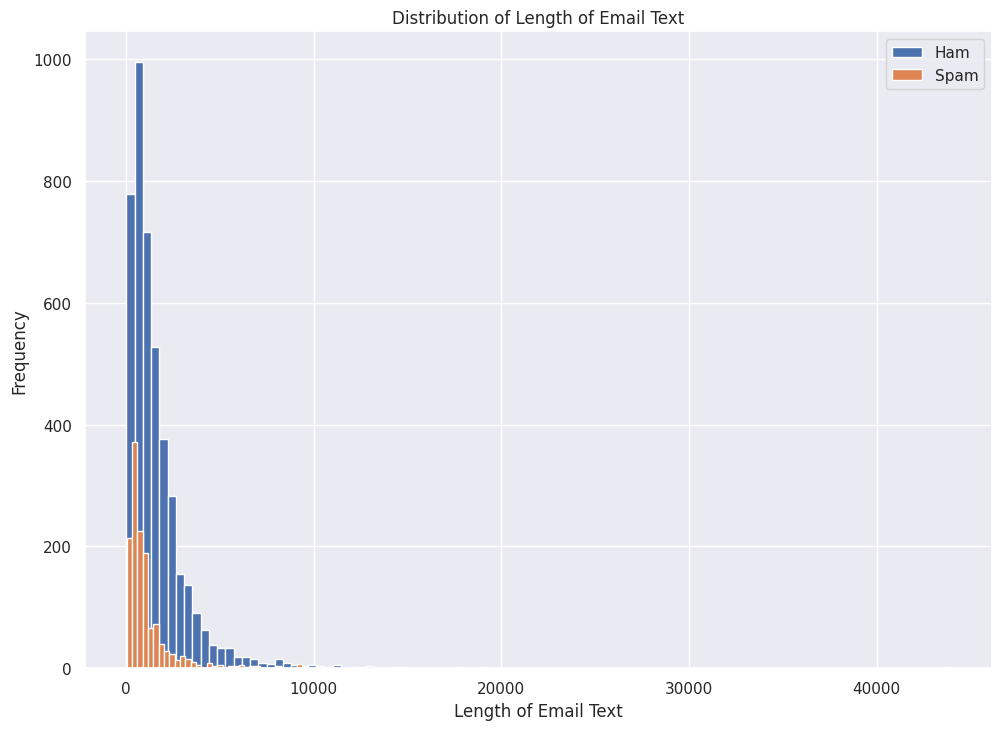

In [11]:
#data_frame['length'].plot(bins=100, kind='hist')
#Length of characters for ham emails is more as compared to spam emails
sns.set(rc={'figure.figsize':(11.7,8.27)})
ham_messages_length =  data_frame[data_frame['spam']==0]
spam_messages_length =  data_frame[data_frame['spam']==1]

ham_messages_length['length'].plot(bins=100, kind='hist',label = 'Ham')
spam_messages_length['length'].plot(bins=100, kind='hist',label = 'Spam')
#sns.distplot(ham_messages_length['length'], bins=10, norm_hist = True, label = 'Ham')
#sns.distplot(spam_messages_length['length'], bins=10, norm_hist = True, label = 'Spam')
plt.title('Distribution of Length of Email Text')
plt.xlabel('Length of Email Text')
plt.legend()


#ax = sns.distplot(ham_words_length, norm_hist = True, bins = 30, label = 'Ham')
#ax = sns.distplot(spam_words_length, norm_hist = True, bins = 30, label = 'Spam')

#plt.legend()
#plt.title('Distribution of Number of Words')
#plt.xlabel('Number of Words')
#plt.show()

In [12]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
#data_frame['spam']==0
data_frame[data_frame['spam']==0].text.values

ham_words_length = [len(word_tokenize(title)) for title in data_frame[data_frame['spam']==0].text.values]
spam_words_length = [len(word_tokenize(title)) for title in data_frame[data_frame['spam']==1].text.values]
print(max(ham_words_length))
print(max(spam_words_length))

8479
6131


<ipython-input-14-a6b1e82ef385>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ham_words_length, norm_hist = True, bins = 30, label = 'Ham')
<ipython-input-14-a6b1e82ef385>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(spam_words_length, norm_hist = True, bins = 30, label = 'Spam'

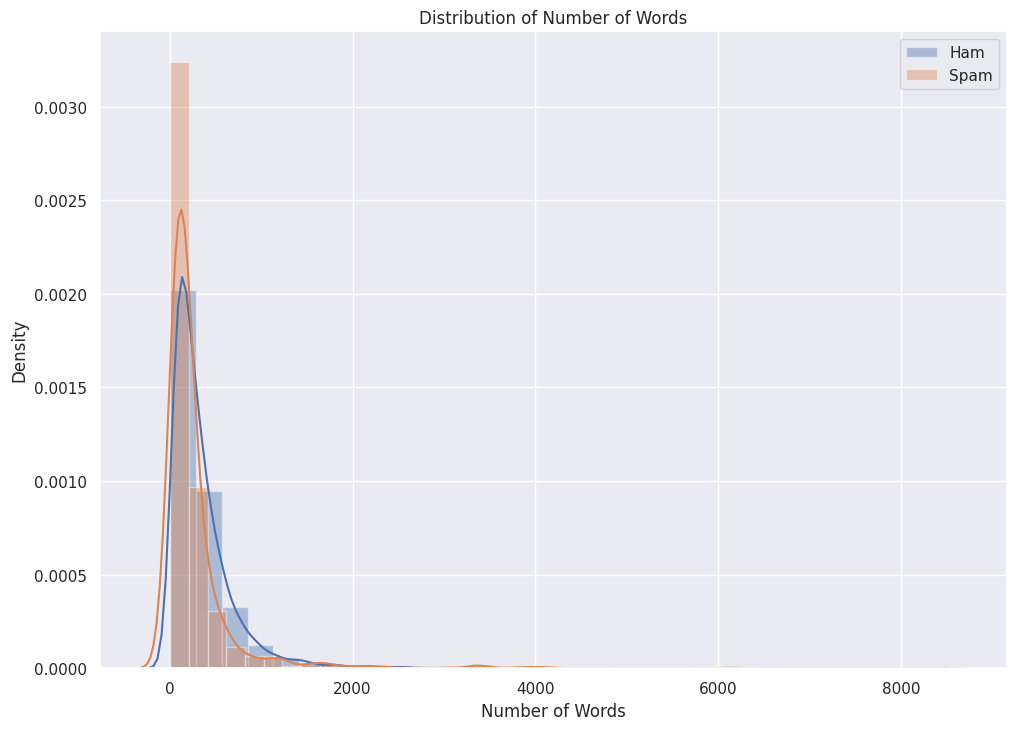

In [14]:
#There is spike in spam emails with less number of words
#Even when our dataset include 24 percent of spam emails out of total emails-
#Looks like Spam emails have less words as compared to ham emails
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(ham_words_length, norm_hist = True, bins = 30, label = 'Ham')
ax = sns.distplot(spam_words_length, norm_hist = True, bins = 30, label = 'Spam')
#ham_words_length.plot(bins=100, kind='hist',label = 'Ham')
#spam_words_length.plot(bins=100, kind='hist',label = 'Spam')


plt.title('Distribution of Number of Words')
plt.xlabel('Number of Words')
plt.legend()

plt.show()


<ipython-input-15-59fb3d5cd4e2>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ham_meanword_length, norm_hist = True, bins = 30, label = 'Ham')
<ipython-input-15-59fb3d5cd4e2>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(spam_meanword_length , norm_hist = True, bins = 30, label = 'Spam')

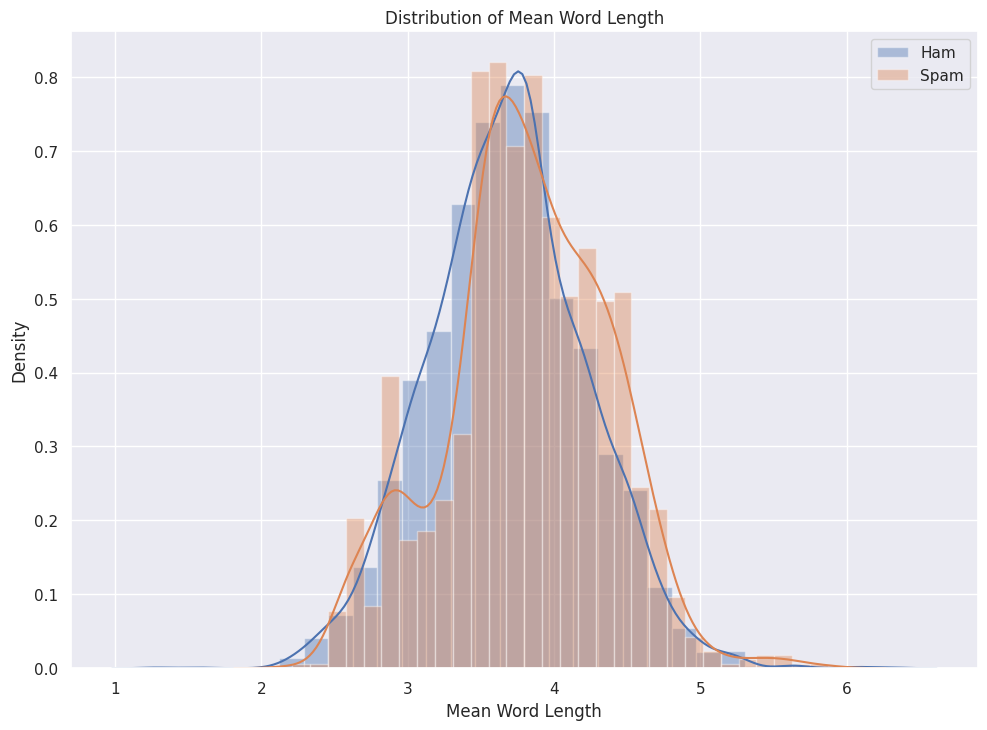

In [15]:
def mean_word_length(x):
    word_lengths = np.array([])
    for word in word_tokenize(x):
        word_lengths = np.append(word_lengths, len(word))
    return word_lengths.mean()

ham_meanword_length = data_frame[data_frame['spam']==0].text.apply(mean_word_length)
spam_meanword_length = data_frame[data_frame['spam']==1].text.apply(mean_word_length)


sns.distplot(ham_meanword_length, norm_hist = True, bins = 30, label = 'Ham')
sns.distplot(spam_meanword_length , norm_hist = True, bins = 30, label = 'Spam')
plt.title('Distribution of Mean Word Length')
plt.xlabel('Mean Word Length')
plt.legend()
plt.show()

#There is not a significant difference for the length of words used by ham and spam emails

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-16-721528bb46f3>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ham_stopwords, norm_hist = True, label = 'Ham')
<ipython-input-16-721528bb46f3>:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

Ham Mean: 0.278
Spam Mean: 0.281


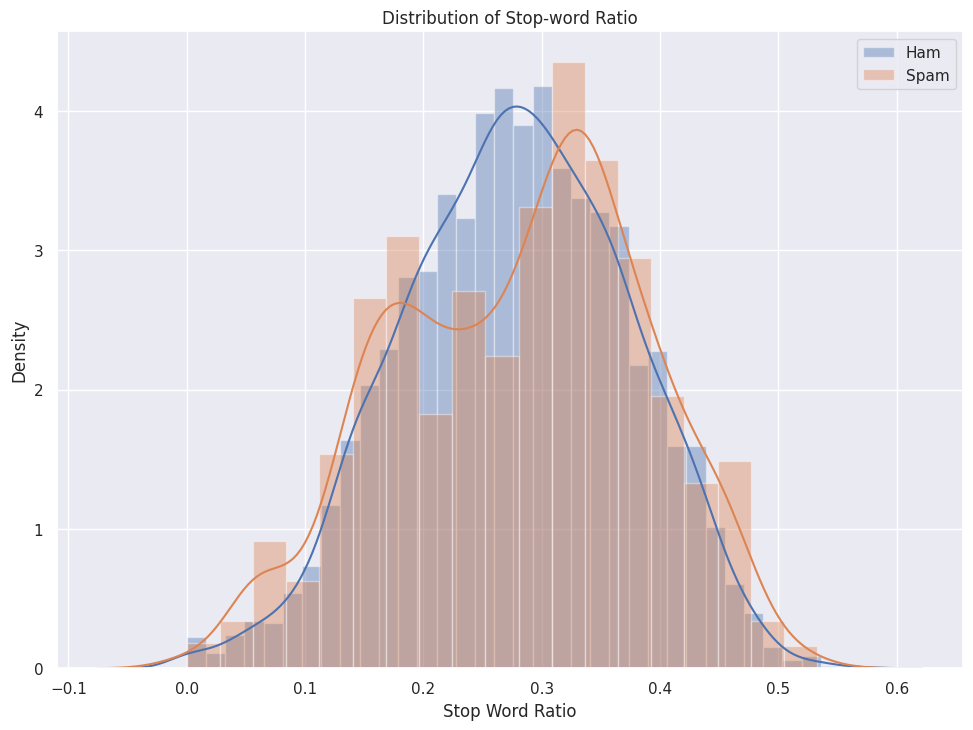

In [16]:
#Checking ratio of stop words
#Both spam and ham email contain stopwords
#All Spam emails contain stop words with a mean of 0.281
#All Ham emails contain stop words with a mean of 0.278
#But we can see from the graph, spam email contain high stop words ratio as compared to ham emails.
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def stop_words_ratio(x):
    num_total_words = 0
    num_stop_words = 0
    for word in word_tokenize(x):
        if word in stop_words:
            num_stop_words += 1
        num_total_words += 1
    return num_stop_words/num_total_words


ham_stopwords = data_frame[data_frame['spam']==0].text.apply(stop_words_ratio)
spam_stopwords = data_frame[data_frame['spam']==1].text.apply(stop_words_ratio)


sns.distplot(ham_stopwords, norm_hist = True, label = 'Ham')
sns.distplot(spam_stopwords,  label = 'Spam')

print('Ham Mean: {:.3f}'.format(ham_stopwords.values.mean()))
print('Spam Mean: {:.3f}'.format(spam_stopwords.values.mean()))
plt.title('Distribution of Stop-word Ratio')
plt.xlabel('Stop Word Ratio')
plt.legend()

In [17]:
spam_stopwords

0       0.230769
1       0.277778
2       0.397727
3       0.191919
4       0.396226
          ...   
1363    0.342105
1364    0.365854
1365    0.437500
1366    0.446809
1367    0.320024
Name: text, Length: 1368, dtype: float64

Spam percentage = 23.88268156424581 %
Ham percentage = 76.11731843575419 %


<Axes: ylabel='Frequency'>

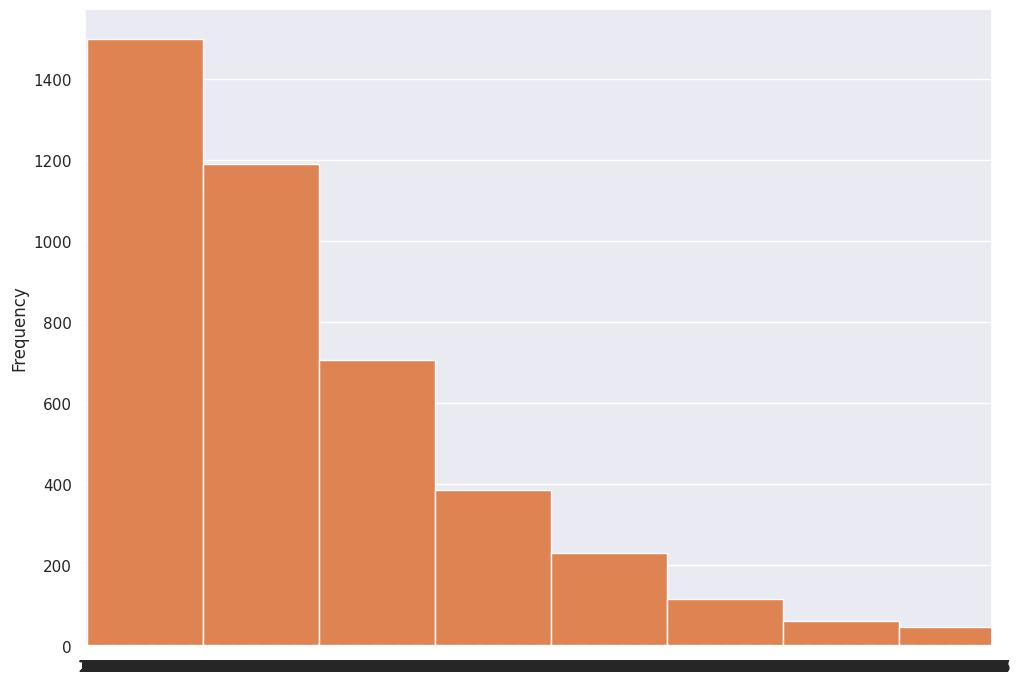

In [18]:
# Let's divide the messages into spam and ham
ham = data_frame[data_frame['spam']==0]
spam = data_frame[data_frame['spam']==1]
spam['length'].plot(bins=60, kind='hist')
ham['length'].plot(bins=60, kind='hist')
data_frame['Ham(0) and Spam(1)'] = data_frame['spam']
print( 'Spam percentage =', (len(spam) / len(data_frame) )*100,"%")
print( 'Ham percentage =', (len(ham) / len(data_frame) )*100,"%")
sns.countplot(data_frame['Ham(0) and Spam(1)'], label = "Count")

#word_cloud_obj = generate_word_cloud()
#word_cloud_obj.word_cloud(ham["clean_text"], "ham_word_cloud.png")
#word_cloud_obj.word_cloud(spam["clean_text"], "spam_word_cloud.png")
#text_spam = " ".join(review for review in spam["clean_text"])

##Generating Word Clouds

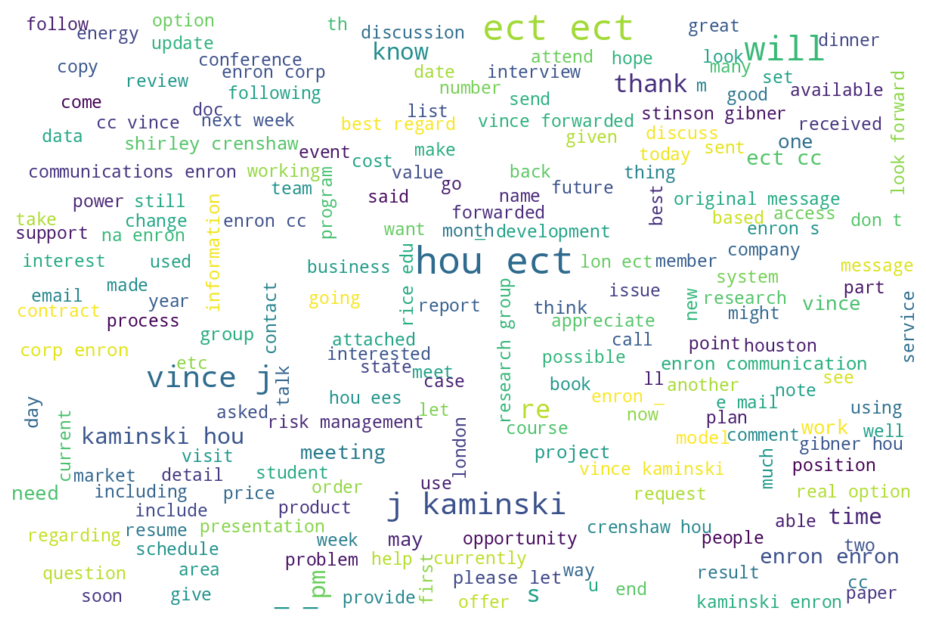

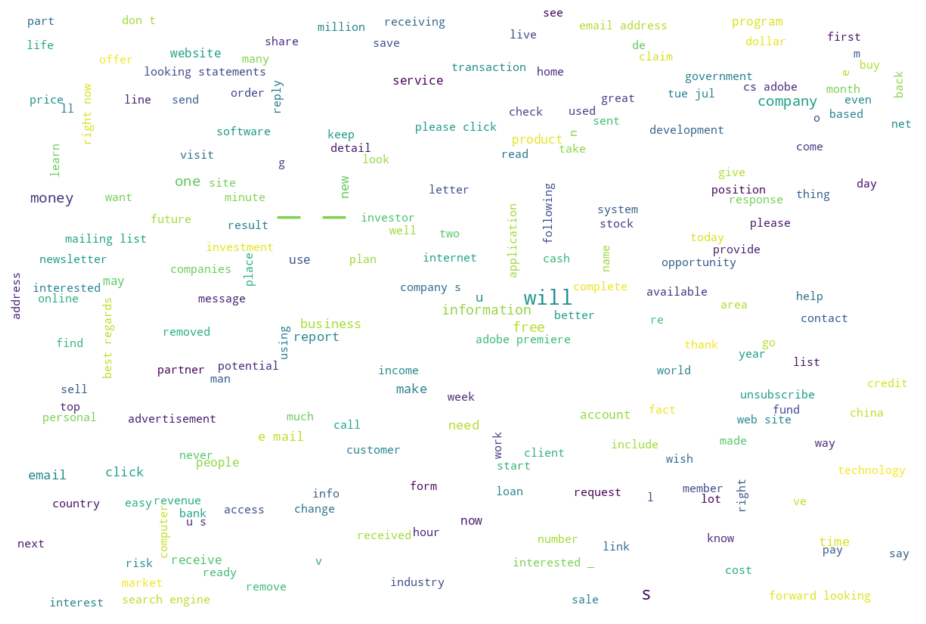

In [19]:
word_cloud_obj = generate_word_cloud()
word_cloud_obj.word_cloud(ham["text"], "ham_word_cloud.png")
word_cloud_obj.word_cloud(spam["text"], "spam_word_cloud.png")


In [20]:
data_clean_obj = data_cleaning()
# Let's test the newly added function
#data_frame['clean_text'] = data_frame['text'].apply(message_cleaning)
#data_frame['clean_text'] = data_frame['text'].apply(data_clean_obj.message_cleaning)
data_frame['clean_text'] = data_clean_obj.apply_to_column(data_frame['text'])

In [21]:
data_frame.head()

,text,spam,length,Ham(0) and Spam(1),clean_text
0,Subject: naturally irresistible your corporate...,1,1484,1,Subject naturally irresistible corporate ident...
1,Subject: the stock trading gunslinger fanny i...,1,598,1,Subject stock trading gunslinger fanny merrill...
2,Subject: unbelievable new homes made easy im ...,1,448,1,Subject unbelievable new homes made easy im wa...
3,Subject: 4 color printing special request add...,1,500,1,Subject 4 color printing special request addit...
4,"Subject: do not have money , get software cds ...",1,235,1,Subject money get software cds software compat...


In [22]:
data_obj.data_frame.head()

,text,spam,length,Ham(0) and Spam(1),clean_text
0,Subject: naturally irresistible your corporate...,1,1484,1,Subject naturally irresistible corporate ident...
1,Subject: the stock trading gunslinger fanny i...,1,598,1,Subject stock trading gunslinger fanny merrill...
2,Subject: unbelievable new homes made easy im ...,1,448,1,Subject unbelievable new homes made easy im wa...
3,Subject: 4 color printing special request add...,1,500,1,Subject 4 color printing special request addit...
4,"Subject: do not have money , get software cds ...",1,235,1,Subject money get software cds software compat...


In [ ]:
data_obj.write_to_csvfile("processed_file.csv")

In [28]:
#APPLY COUNT VECTORIZER TO OUR MESSAGES LIST

# Define the cleaning pipeline we defined earlier
#vectorizer = CountVectorizer()
cv_object = apply_embeddding_and_model()
spamham_countvectorizer = cv_object.apply_count_vector(data_frame['clean_text'])


In [29]:
#Separating Descriptive and Target Feature
X = spamham_countvectorizer
label = data_frame['spam'].values
y = label

#**Applying All Initialized Algorithms

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1315
           1       0.96      1.00      0.98       404

    accuracy                           0.99      1719
   macro avg       0.98      0.99      0.99      1719
weighted avg       0.99      0.99      0.99      1719

test set

Accuracy Score: 0.9901105293775451
F1 Score: 0.979293544457978
Recall: 0.995049504950495
Precision: 0.9640287769784173


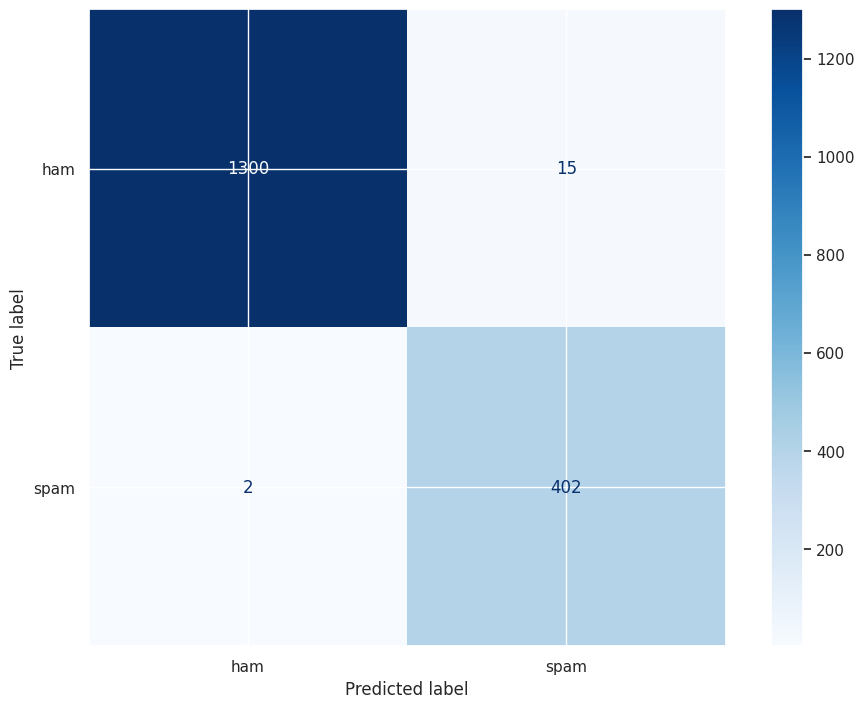

No Skill: ROC AUC=0.500
Naive Bayes: ROC AUC=0.996


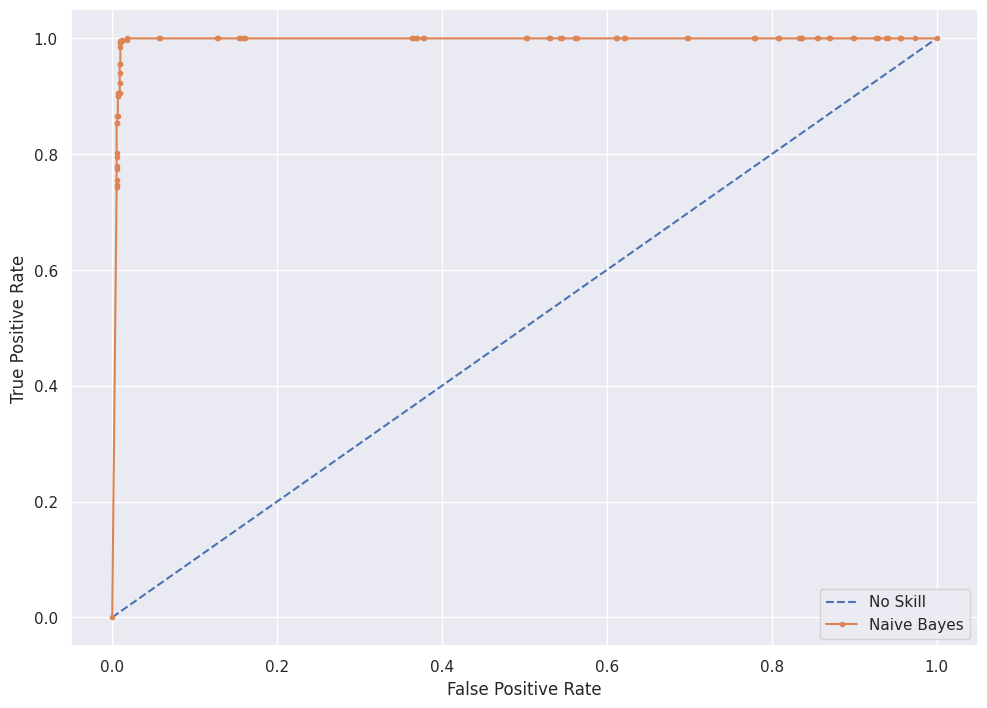

In [30]:
cv_object.apply_naive_bayes(X,y)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1306
           1       0.97      0.99      0.98       413

    accuracy                           0.99      1719
   macro avg       0.98      0.99      0.99      1719
weighted avg       0.99      0.99      0.99      1719

test set

Accuracy Score: 0.9906922629435718
F1 Score: 0.9808153477218226
Recall: 0.9903147699757869
Precision: 0.9714964370546318


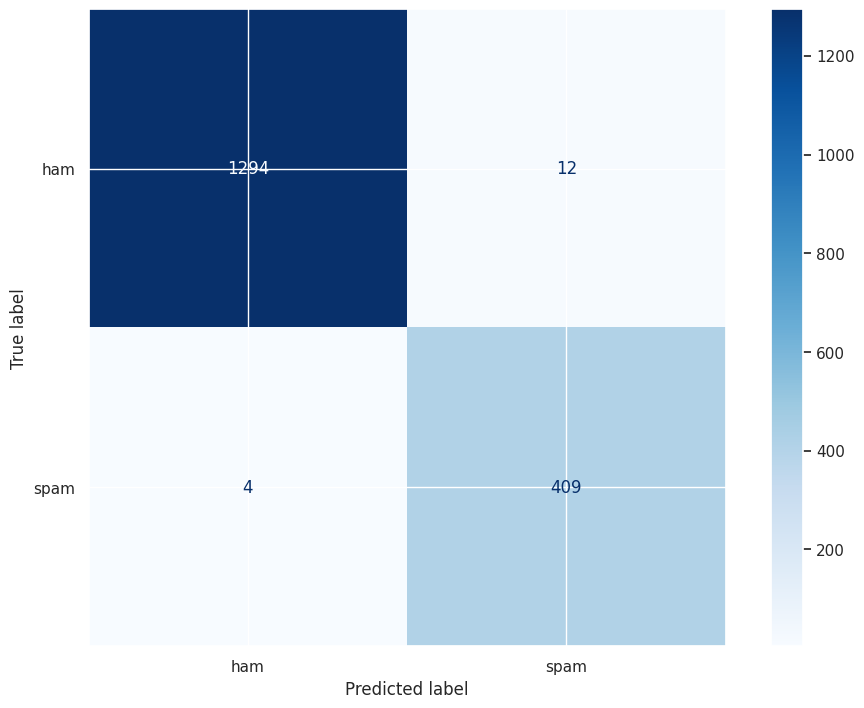

No Skill: ROC AUC=0.500
SVM: ROC AUC=0.997


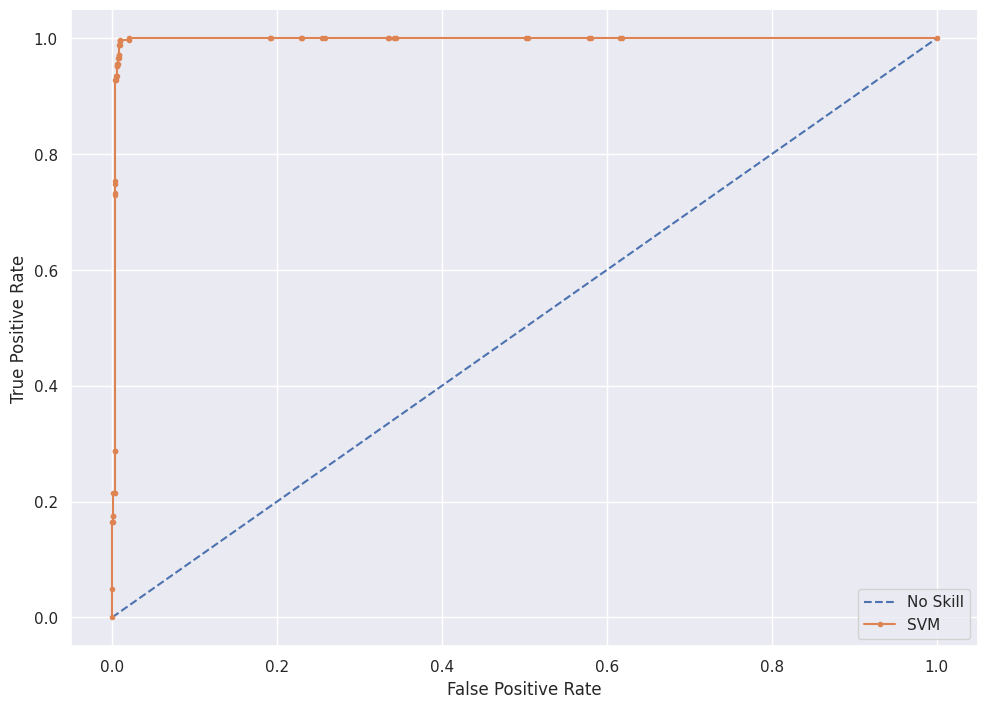

In [31]:
cv_object.apply_svm(X,y)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1278
           1       0.92      0.93      0.92       441

    accuracy                           0.96      1719
   macro avg       0.95      0.95      0.95      1719
weighted avg       0.96      0.96      0.96      1719

Test set evaluation:

Accuracy Score: 0.9604421175101804
F1 Score: 0.923076923076923
Recall: 0.9251700680272109
Precision: 0.9209932279909706


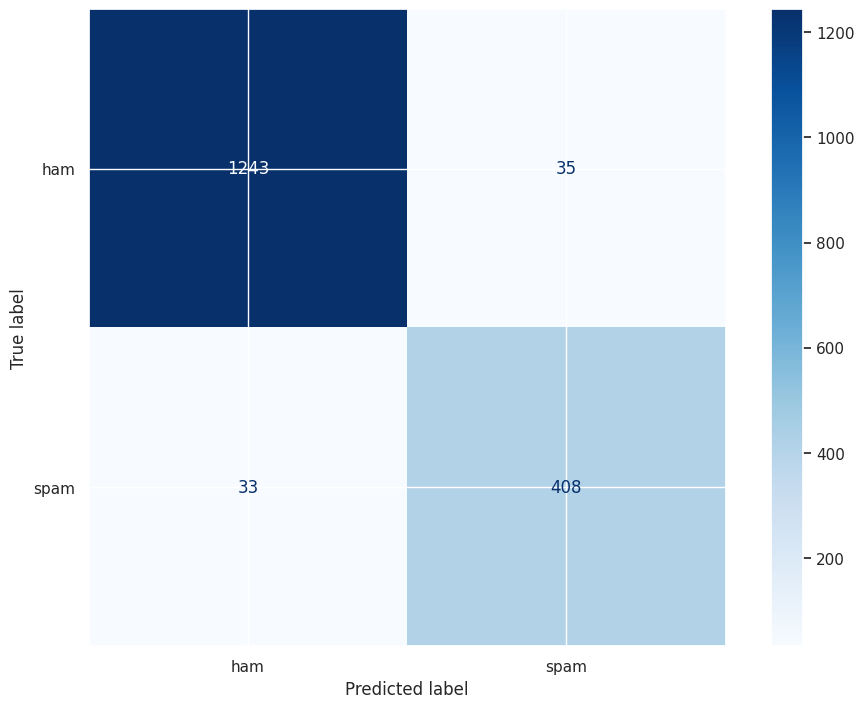

No Skill: ROC AUC=0.500
J48: ROC AUC=0.949


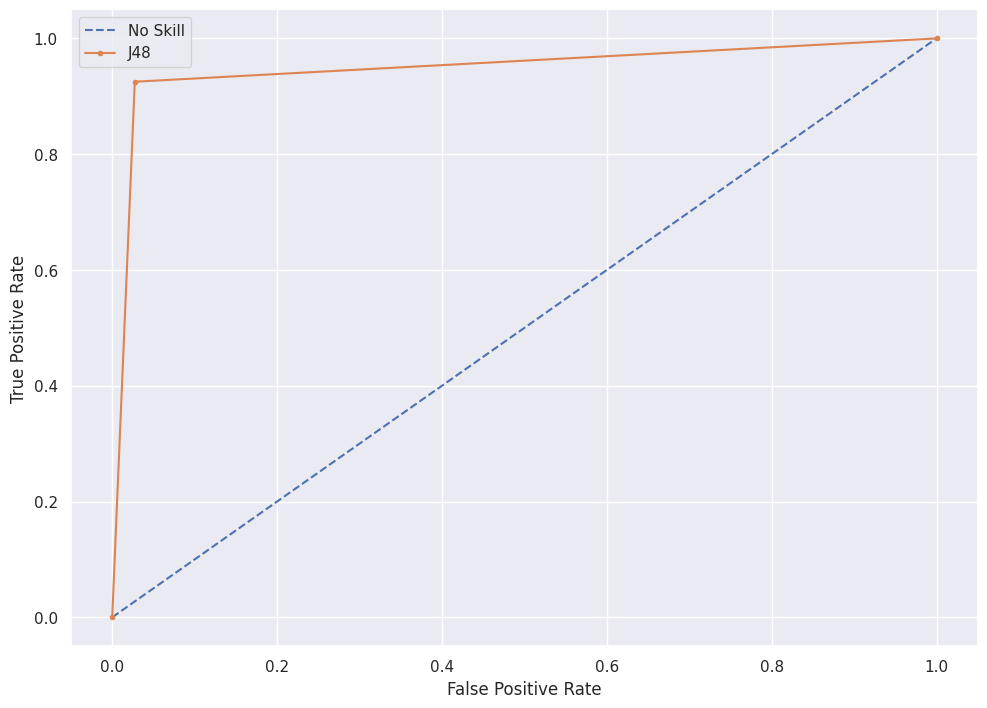

In [32]:
cv_object.apply_j48(X,y)

In [ ]:
import pickle
import pandas as pd
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

# Load the trained Naive Bayes model
with open('svm_model.pkl', 'rb') as file:
    NB_classifier = pickle.load(file)

# Load the CountVectorizer
with open('vectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file)

def classify_email(email):
    # Preprocess the email
    cleaned_email = data_cleaning().message_cleaning(email)
    # Vectorize the preprocessed email
    email_vector = vectorizer.transform([cleaned_email])
    # Predict the class (spam or ham)
    prediction = NB_classifier.predict(email_vector)[0]

    return prediction

# User input
email = input("Enter an email: ")

# Load the training dataset from CSV
dataset = pd.read_csv('processed_file.csv')

# Extract the training emails from the dataset
training_emails = dataset['clean_text'].tolist()

# Fit the CountVectorizer on training data
vectorizer.fit(training_emails)

# Classify the email
prediction = classify_email(email)

# Output the prediction
if prediction == 1:
    print("The email is classified as spam.")
else:
    print("The email is classified as ham.")


Enter an email: check this prize offer from us we're gonna give you ree
The email is classified as spam.
